In [1]:
# preamble 
# import some packages that we'll need!
import tempfile
#from Pillow import Image
import matplotlib.pyplot as plt
import numpy as np
import rasterio as rio
import rpy2.robjects as ro
import rpy2.robjects.numpy2ri
import rpy2.robjects.packages as rpackages

# activate rpy2’s numpy translation layer
rpy2.robjects.numpy2ri.activate()

# Running rayshader with rpy2
Note, this code is built from: https://www.gpxz.io/blog/rayshading-in-python 

### Here is an example of what rayshader can produce:
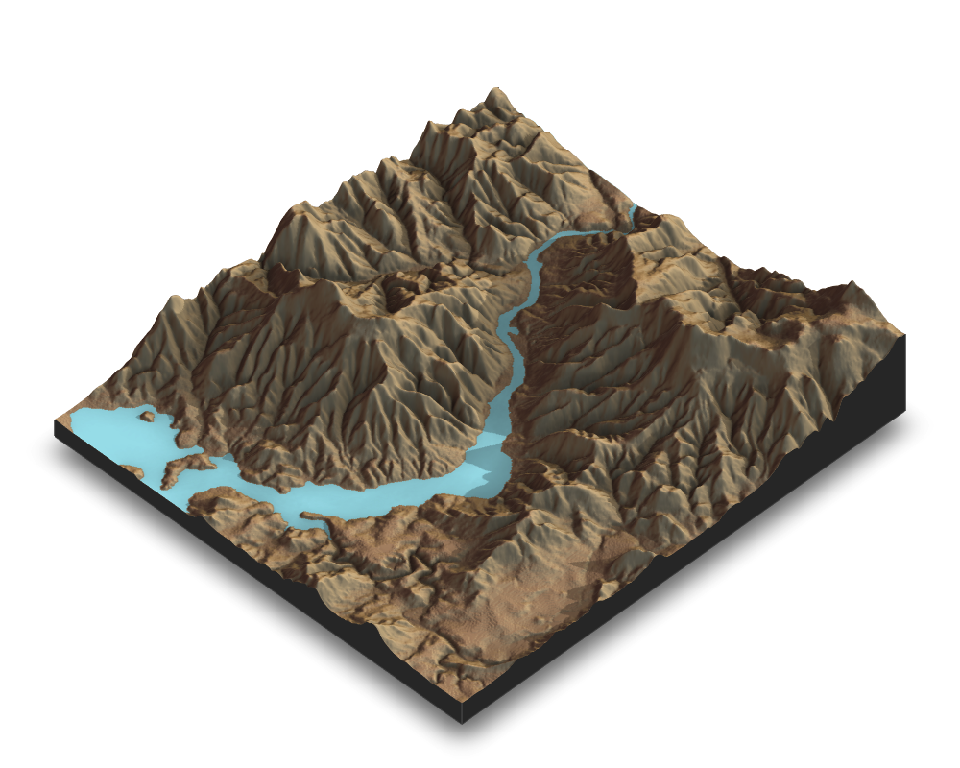

### To make our own, we need to load the raster that we want to plot!

In [2]:
zip_url = "https://zenodo.org/record/7004454/files/1987_Tweedsmuir_SfM_3153_40m_Ref_Tweedsmuir_ArcticDEM_3153_40m_nuth_x-1.48_y%2B2.60_z%2B13.35_align.tif?download=1"
with rio.open(zip_url) as f:
    #z = f.read(1)
    
#path = '/Users/msharp/Downloads/1950_Tweedsmuir_3153_40m_Tweedsmuir_ArcticDEM_3153_40m_nuth_x-2.31_y+1.26_z-11.54_align.tif'
#path = '/Users/msharp/Downloads/1987_Tweedsmuir_SfM_3153_40m_Ref_Tweedsmuir_ArcticDEM_3153_40m_nuth_x-1.48_y+2.60_z+13.35_align.tif'
#with rio.open(path) as f:
    z = f.read(1)

### We can visualize this DEM in 2D:

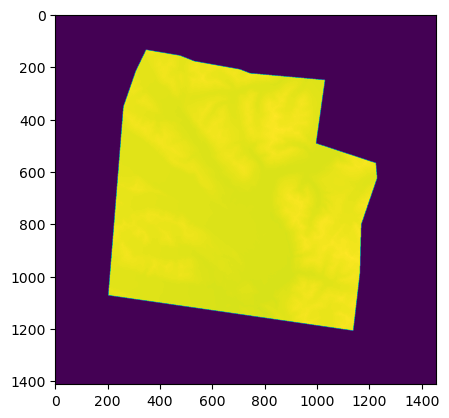

In [3]:
# plot the DEM in 2d
plt.imshow(z)

### This shows the elevation, but it would be much more intuitive in 3D... Cue rayshader!

In [4]:
def rayshade(z, img_path=None, zscale=10, fov=0, theta=135, zoom=0.75, phi=45, windowsize=(1000, 1000)):
    
    # Output path
    if not img_path:
        img_path = tempfile.NamedTemporaryFile(suffix='.png').name
    
    # Import needed packages
    rayshader = rpackages.importr('rayshader')
    
    # Convert array to matrix
    z = np.asarray(z)
    
    # Reduce down to a zero-reference elevation
    #z = z - np.amin(z [z != -9999])
    z[z < 0] = np.NaN
    
    rows, cols = z.shape
    z_mat = ro.r.matrix(z, nrow=rows, ncol=cols)
    
    
    ro.globalenv['elmat'] = z_mat
    
    
    # Save python state to r
    ro.globalenv['img_path'] = img_path
    ro.globalenv['zscale'] = zscale
    ro.globalenv['fov'] = fov
    ro.globalenv['theta'] = theta
    ro.globalenv['zoom'] = zoom
    ro.globalenv['phi'] = phi
    ro.globalenv['windowsize'] = ro.IntVector(windowsize)
   
    # Do the render
    ro.r('''
        elmat %>%
          sphere_shade(texture = "desert") %>%
          add_water(detect_water(elmat), color = "desert") %>%
          add_shadow(ray_shade(elmat, zscale = 3), 0.5) %>%
          add_shadow(ambient_shade(elmat), 0) %>%
          plot_3d(elmat, zscale = zscale, fov = fov, theta = theta, zoom = zoom, phi = phi, windowsize = windowsize)
        Sys.sleep(0.2)
        render_snapshot(img_path)
    ''')
    
    # Return path
    return img_path

### Finally, call the new rayshade function and render the image!

In [ ]:
img_path = "/Users/msharp/Desktop/tweeds_rayshader.png"

img_path = rayshade(z, img_path = img_path, zscale = 20, theta=65, phi = 35)

from IPython.display import Image
Image(filename=img_path) 

## There are lots more features you can add in!
e.g. ...
 * add an image as an overlay
 * export as an stl file for 3D printing
 

![rayshader_examples.png](attachment:rayshader_examples.png)